<a href="https://colab.research.google.com/github/sujithcplusplus/Music_popularity_prediction/blob/main/Music_popularity_prediction_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random

In [6]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Music Popularity Predictions/Dataset.zip','r') #INSERT FILE PATH
zip_ref.extractall()
zip_ref.close()

In [7]:
df = pd.read_csv('/content/spotify_data.csv')

In [8]:
df.shape

(1159764, 20)

In [9]:
df = df.drop(['artist_name','track_name','track_id','genre','Unnamed: 0'],axis = 1)

In [10]:
df['duration_minutes'] = df['duration_ms'] / 60000
df = df.drop('duration_ms', axis=1)

In [11]:
correlation_matrix = df.corr()

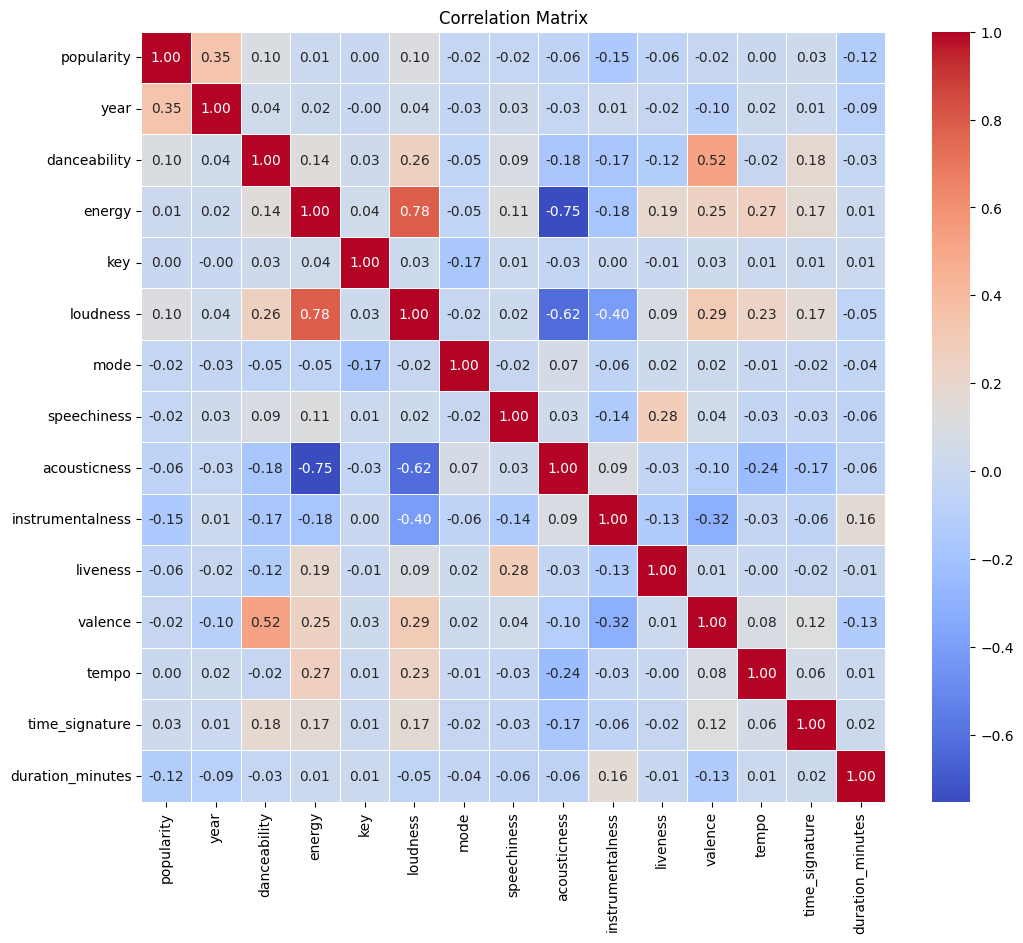

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

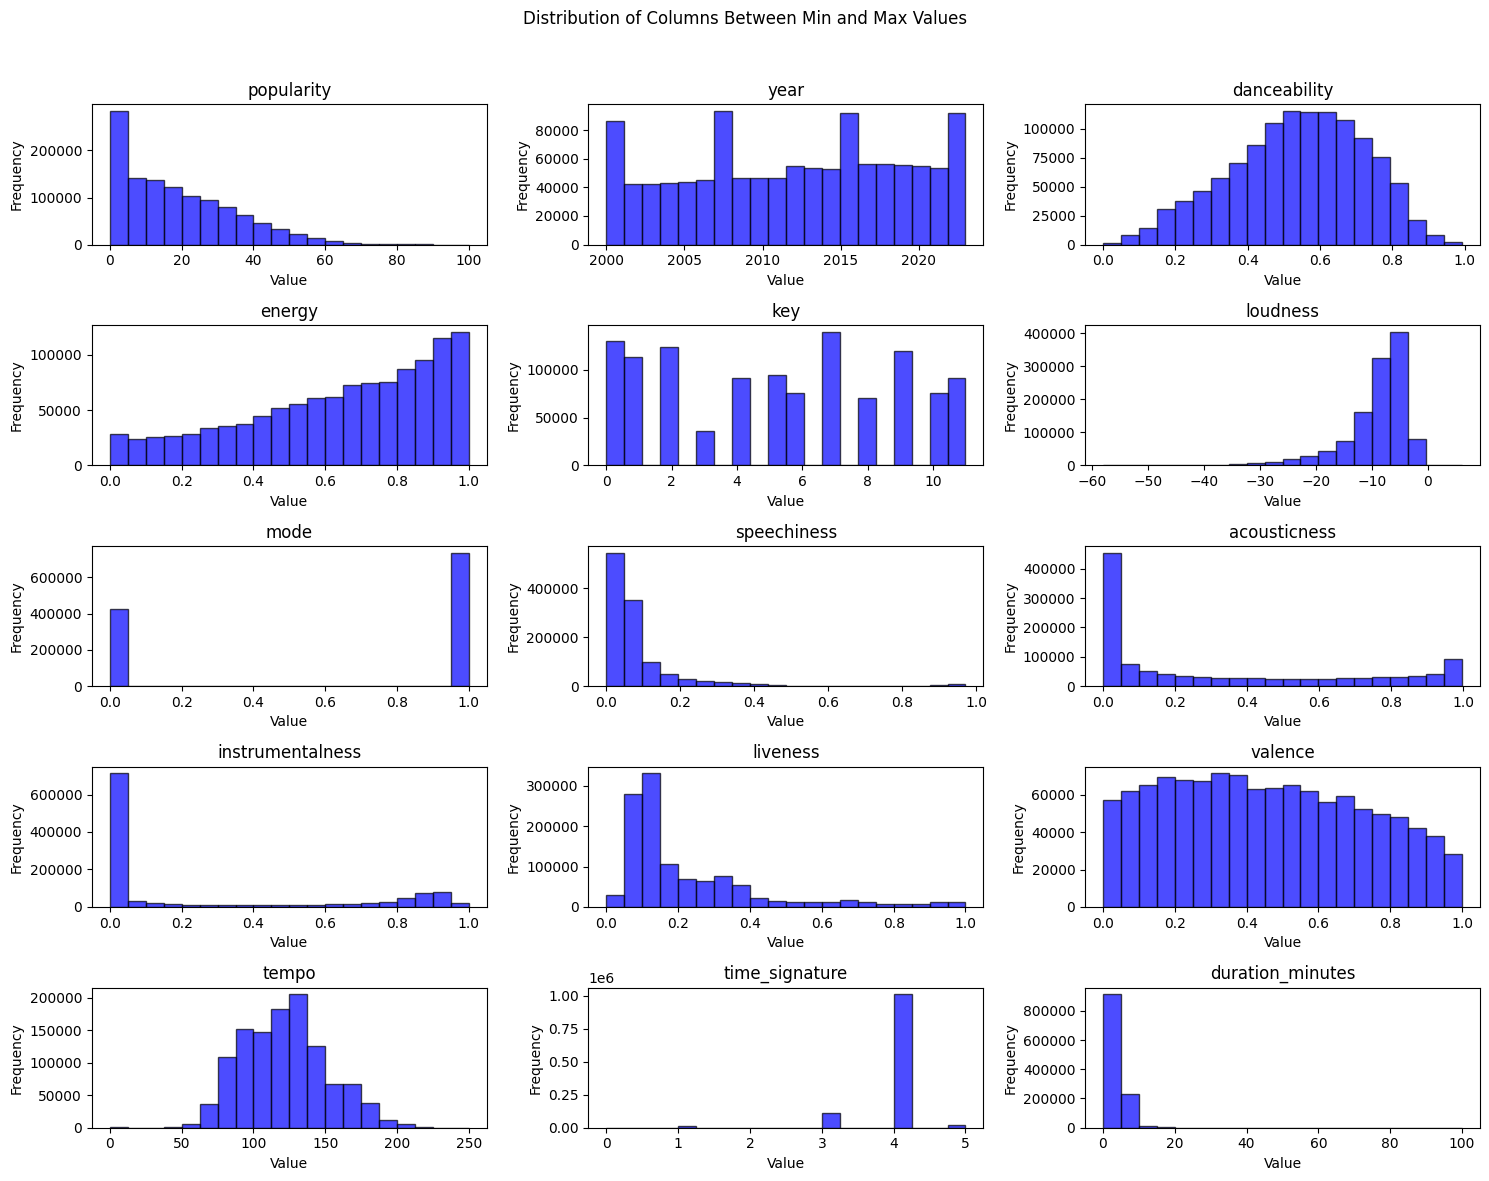

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 12))
fig.suptitle('Distribution of Columns Between Min and Max Values')

axes = axes.flatten()


for i, column in enumerate(df.columns):
    ax = axes[i]
    ax.hist(df[column], bins=20, color='blue', alpha=0.7, edgecolor='black')
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])

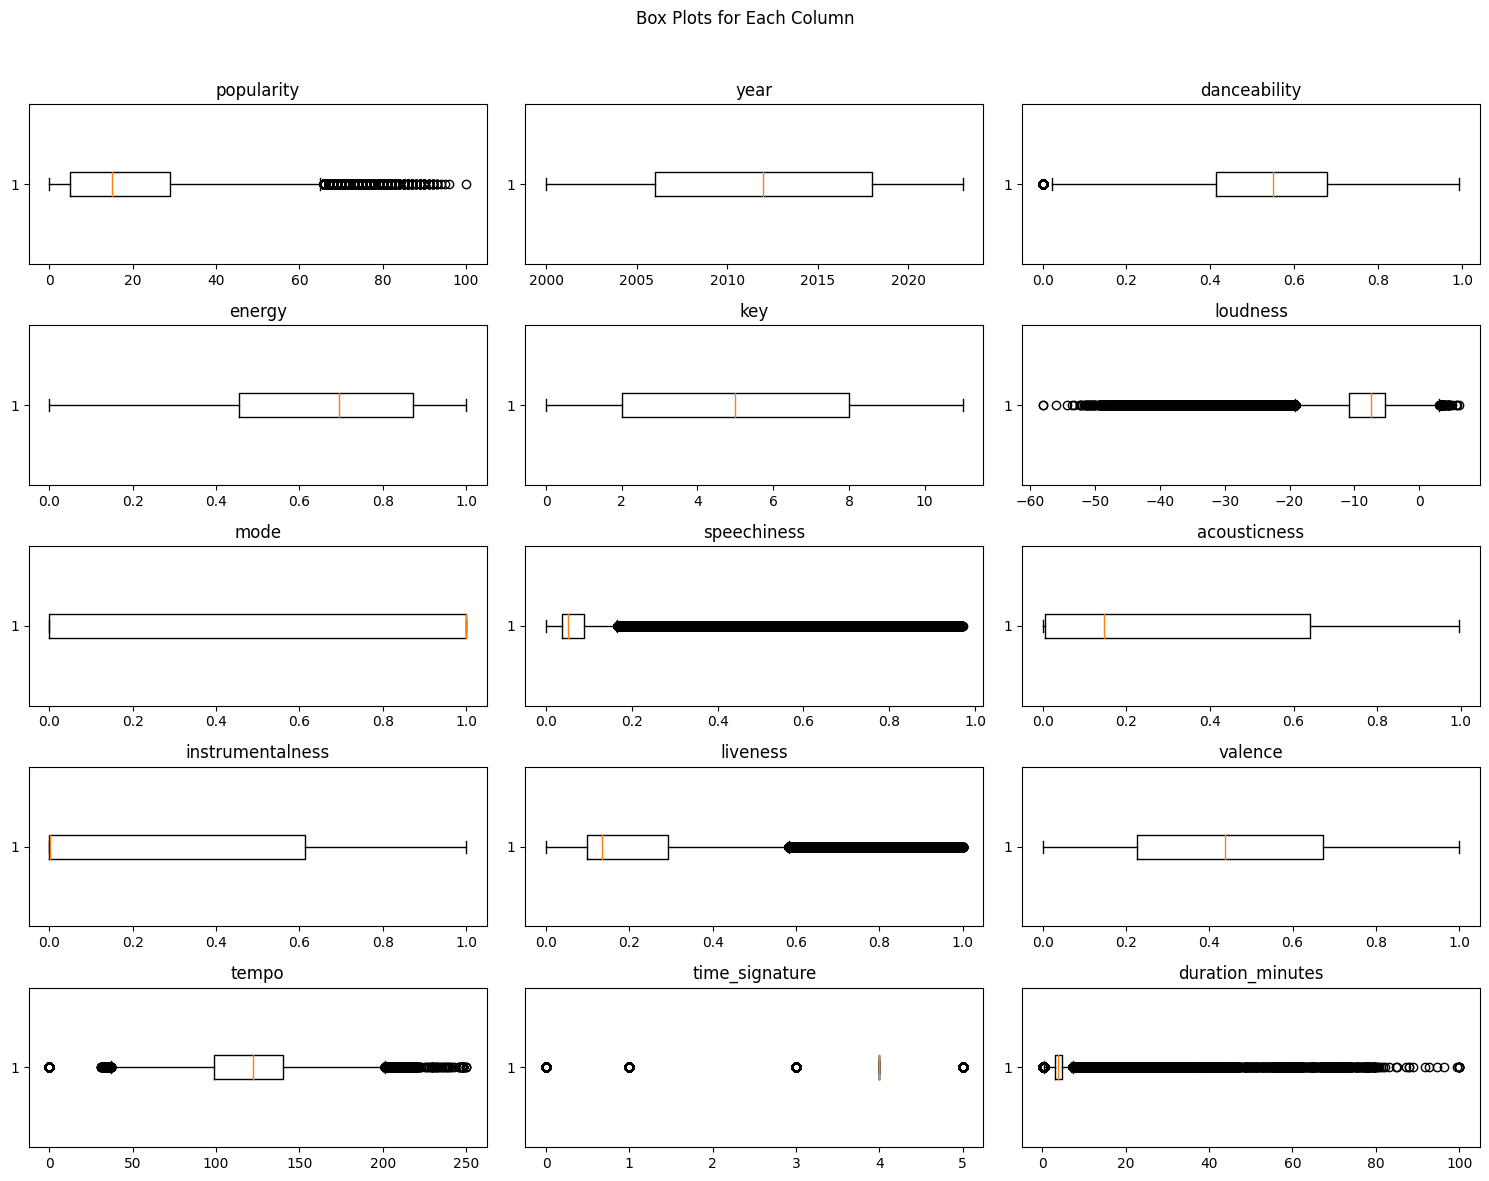

In [14]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 12))
fig.suptitle('Box Plots for Each Column')


axes = axes.flatten()

for i, column in enumerate(df.columns):
    ax = axes[i]
    ax.boxplot(df[column], vert=False)
    ax.set_title(column)


for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [15]:
split_index = int(0.999 * len(df))
df_test = df.iloc[split_index:]
df = df.iloc[:split_index]

In [16]:
df_test.shape

(1160, 15)

In [17]:
df.max()

popularity           100.00000
year                2023.00000
danceability           0.99300
energy                 1.00000
key                   11.00000
loudness               6.17200
mode                   1.00000
speechiness            0.97100
acousticness           0.99600
instrumentalness       1.00000
liveness               1.00000
valence                1.00000
tempo                249.99300
time_signature         5.00000
duration_minutes     100.00825
dtype: float64

In [18]:
columns_for_pca = ['energy', 'loudness', 'acousticness']
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(df[columns_for_pca]), columns=['ELA_PCA_1', 'ELA_PCA_2'])
df = df.drop(columns = columns_for_pca)
df = pd.concat([df,df_pca], axis = 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1158604 entries, 0 to 1158603
Data columns (total 14 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   popularity        1158604 non-null  int64  
 1   year              1158604 non-null  int64  
 2   danceability      1158604 non-null  float64
 3   key               1158604 non-null  int64  
 4   mode              1158604 non-null  int64  
 5   speechiness       1158604 non-null  float64
 6   instrumentalness  1158604 non-null  float64
 7   liveness          1158604 non-null  float64
 8   valence           1158604 non-null  float64
 9   tempo             1158604 non-null  float64
 10  time_signature    1158604 non-null  int64  
 11  duration_minutes  1158604 non-null  float64
 12  ELA_PCA_1         1158604 non-null  float64
 13  ELA_PCA_2         1158604 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 123.8 MB


In [19]:
numerical_columns_to_normalize = ['tempo','duration_minutes','ELA_PCA_1', 'ELA_PCA_2']
scaler = MinMaxScaler()
df[numerical_columns_to_normalize] = scaler.fit_transform(df[numerical_columns_to_normalize])

In [20]:
categorical_columns = ['year','key', 'mode', 'time_signature']
df = pd.get_dummies(df, columns=categorical_columns)

In [21]:
X = df.drop(['popularity'],axis = 1)
y = df['popularity']

In [22]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.1,random_state=42)

In [23]:
X_train.shape

(1042743, 52)

In [24]:
X_val.shape

(115861, 52)

In [25]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']



  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

In [26]:
input_shape = X.shape[1]
neurons = 128
activation_function = tf.nn.leaky_relu
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
epochs = 300
loss = 'mse'
metrics = ['mae']
batch_size = 4096

In [27]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(neurons, input_dim = input_shape, activation = activation_function),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(neurons,activation = activation_function,kernel_initializer='ones',activity_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(neurons,activation = activation_function,kernel_initializer='ones',activity_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(neurons,activation = activation_function,kernel_initializer='ones',activity_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(neurons,activation = activation_function,kernel_initializer='ones',activity_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(neurons,activation = activation_function,kernel_initializer='ones',activity_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation = activation_function),
    tf.keras.layers.Lambda(lambda x: x * 100)
])

In [28]:
model_1.compile(optimizer = optimizer,
                loss = loss,
                metrics = metrics)

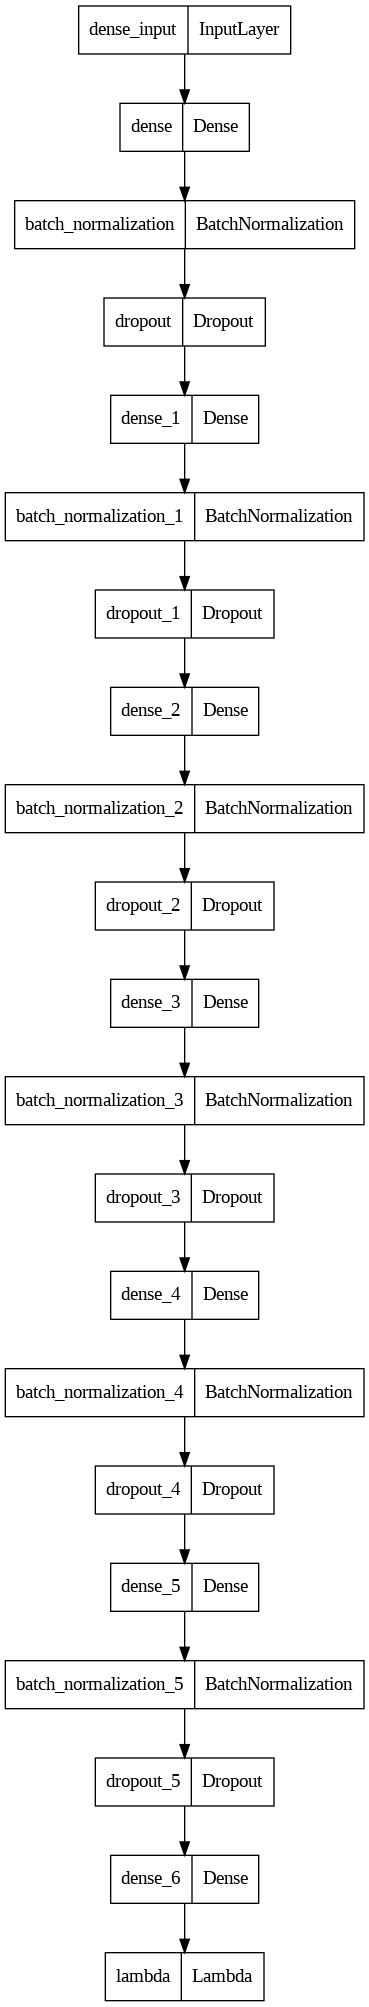

In [29]:
tf.keras.utils.plot_model(model_1)

In [30]:
model_1_history = model_1.fit(X_train,y_train,
            epochs=epochs,
            validation_data = (X_val,y_val),
            batch_size = batch_size)

Epoch 1/300
255/255 [==============================] - 15s 15ms/step - loss: 4318.5586 - mae: 25.2493 - val_loss: 454.2121 - val_mae: 12.9170
Epoch 2/300
255/255 [==============================] - 3s 12ms/step - loss: 1571.7820 - mae: 16.5366 - val_loss: 453.3500 - val_mae: 13.2087
Epoch 3/300
255/255 [==============================] - 3s 13ms/step - loss: 813.0850 - mae: 13.4042 - val_loss: 400.9273 - val_mae: 13.1473
Epoch 4/300
255/255 [==============================] - 3s 14ms/step - loss: 555.1441 - mae: 13.0912 - val_loss: 352.1849 - val_mae: 13.1210
Epoch 5/300
255/255 [==============================] - 4s 16ms/step - loss: 436.0144 - mae: 13.0933 - val_loss: 321.8030 - val_mae: 13.1449
Epoch 6/300
255/255 [==============================] - 3s 11ms/step - loss: 371.5393 - mae: 13.1028 - val_loss: 304.2337 - val_mae: 13.0990
Epoch 7/300
255/255 [==============================] - 3s 11ms/step - loss: 333.8235 - mae: 13.1014 - val_loss: 291.1972 - val_mae: 13.1381
Epoch 8/300
255/2

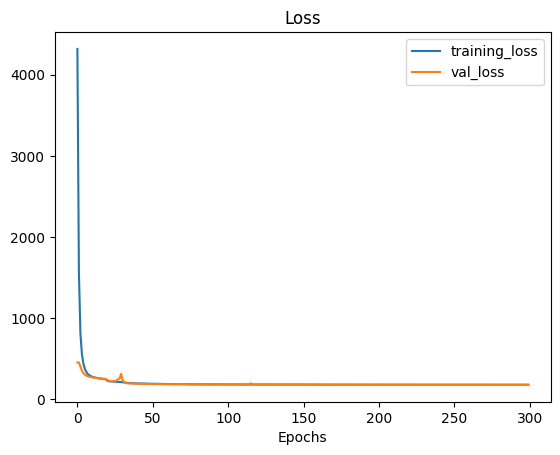

In [31]:
plot_loss_curves(model_1_history)

In [32]:
y_val_pred = model_1.predict(X_val)
mae = mean_absolute_error(y_val,y_val_pred)
mse = mean_squared_error(y_val,y_val_pred)
rmse_val = np.sqrt(mse)
r_square_val = r2_score(y_val,y_val_pred)

3621/3621 [==============================] - 9s 2ms/step


In [33]:
print(f"Mean Absolute Error is: {mae}")
print(f"Mean Squared Error is: {mse}")
print(f"Root Mean Squared Error is: {rmse_val}")
print(f"R-Square Error is: {r_square_val}")

Mean Absolute Error is: 10.563338421707579
Mean Squared Error is: 176.8319613547897
Root Mean Squared Error is: 13.297817917041492
R-Square Error is: 0.3045052946116691


In [34]:
X_val.shape

(115861, 52)

In [35]:
y_val.shape

(115861,)

In [36]:
y_val_pred.shape

(115861, 1)

In [37]:
y_val_pred_series = np.squeeze(y_val_pred)
y_val_pred_series

array([13.527833 , 24.003687 ,  9.484616 , ..., 12.5397   ,  7.0505075,
       23.943502 ], dtype=float32)

In [38]:
y_val_pred_series.shape

(115861,)

In [39]:
X_val['popularity'] = y_val

In [40]:
X_val['predictions'] = y_val_pred_series

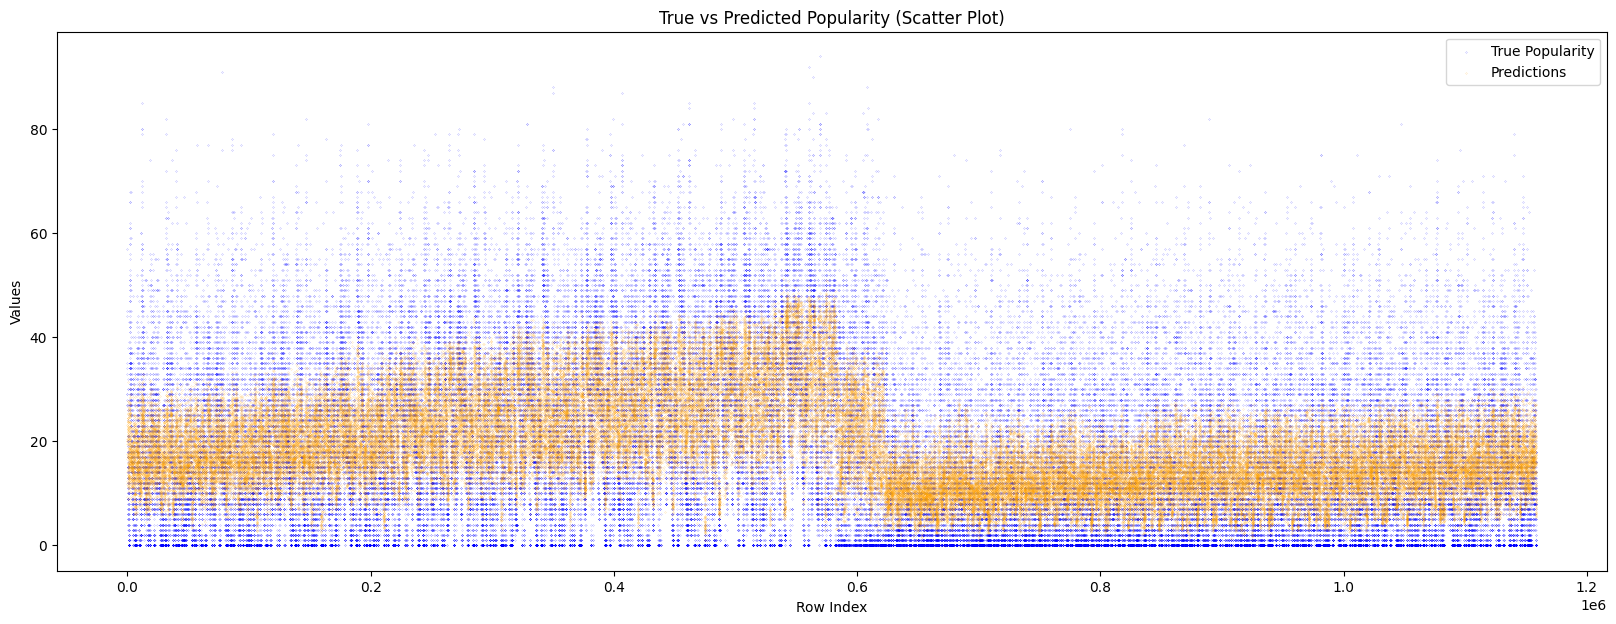

In [41]:
plt.figure(figsize=(20, 7))

plt.scatter(X_val.index, X_val['popularity'], label='True Popularity', color='blue', s=0.01)

plt.scatter(X_val.index, X_val['predictions'], label='Predictions', color='orange',s=0.01)

plt.title('True vs Predicted Popularity (Scatter Plot)')
plt.xlabel('Row Index')
plt.ylabel('Values')
plt.legend()
plt.show()

In [45]:
number = random.randint(0, len(df_test))
df_test.iloc[number]

popularity            24.00000
year                2011.00000
danceability           0.80100
energy                 0.79900
key                   10.00000
loudness              -7.48900
mode                   0.00000
speechiness            0.05270
acousticness           0.26100
instrumentalness       0.00103
liveness               0.09630
valence                0.80500
tempo                112.03400
time_signature         4.00000
duration_minutes       4.36845
Name: 1159301, dtype: float64

In [43]:
def make_new_predictions(model):
  year = int(input("Enter the year (2000-2023): "))
  danceability = float(input("Enter danceability (0 to 1) : "))
  energy = float(input("Enter energy (0 to 1): "))
  key = int(input("Enter key (0-11) int : "))
  loudness = float(input("Enter loudness (0 to 1): "))
  mode = int(input("Enter mode (0 or 1): "))
  speechiness = float(input("Enter speechiness (0 to 1) : "))
  acousticness = float(input("Enter acousticness (0 to 1) : "))
  instrumentalness = float(input("Enter instrumentalness (0 to 1) : "))
  liveness = float(input("Enter liveness (0 to 1): "))
  valence = float(input("Enter valence (0 to 1): "))
  tempo = float(input("Enter tempo (0 to 250): "))
  duration_minutes = float(input("Enter duration in minutes: "))
  time_signature = int(input("Enter time signature (0,1,3,4,5): "))

  dataframe = pd.read_csv('/content/spotify_data.csv')
  new_data = [None,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_minutes]
  dataframe = dataframe.drop(['artist_name','track_name','track_id','genre','Unnamed: 0'],axis = 1)
  dataframe['duration_minutes'] = dataframe['duration_ms'] / 60000
  dataframe = dataframe.drop('duration_ms', axis=1)

  dataframe.loc[len(dataframe)] = new_data

  columns_for_pca = ['energy', 'loudness', 'acousticness']
  pca = PCA(n_components=2)
  dataframe_pca = pd.DataFrame(pca.fit_transform(dataframe[columns_for_pca]), columns=['ELA_PCA_1', 'ELA_PCA_2'])
  dataframe = dataframe.drop(columns = columns_for_pca)
  dataframe = pd.concat([dataframe,dataframe_pca], axis = 1)

  numerical_columns_to_normalize = ['tempo','duration_minutes','ELA_PCA_1', 'ELA_PCA_2']
  scaler = MinMaxScaler()
  dataframe[numerical_columns_to_normalize] = scaler.fit_transform(dataframe[numerical_columns_to_normalize])

  categorical_columns = ['year','key', 'mode', 'time_signature']
  dataframe = pd.get_dummies(dataframe, columns=categorical_columns)

  I = dataframe.drop(['popularity'],axis = 1)

  last_row = I.iloc[-1]
  last_row = last_row.to_numpy().reshape(1, -1)

  predicted_popularity = model_1.predict(last_row)

  return float(predicted_popularity)

In [48]:
prediction = make_new_predictions(model_1)
prediction


Enter the year (2000-2023): 2011
Enter danceability (0 to 1) : 0.801
Enter energy (0 to 1): 0.79900
Enter key (0-11) int : 10
Enter loudness (0 to 1): -7.48900
Enter mode (0 or 1): 0
Enter speechiness (0 to 1) : 0.05270
Enter acousticness (0 to 1) : 0.26100
Enter instrumentalness (0 to 1) : 0.00103
Enter liveness (0 to 1): 0.09630
Enter valence (0 to 1): 0.80500
Enter tempo (0 to 250): 112.03400
Enter duration in minutes: 4.36845
Enter time signature (0,1,3,4,5): 4
1/1 [==============================] - 0s 20ms/step


20.844823837280273